# **CS6120 NLP Final Project:<br>Exploring Sentiment Classification on the <br>"Amazon Fine Food Reviews" Dataset**

## **1. Load Dataset**

In [ ]:
import os
import pandas as pd
import time

def load_amazon_food_reviews(filename, subset=5000):
    """
    1. Load Amazon Fine Food Reviews from pre-downloaded CSV file: Reviews.csv
       (https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews)
    2. Extract relevant fields and return a subset of records.
    3. Converts ratings into binary sentiment labels (1-2: 0, 4-5: 1, drop 3).

    Args:
        filepath: path to the CSV file
        sample_size: max number of samples (subset of 568,454 reviews)
    Returns:
        df: pd.DataFrame of reviews (text and sentiment labels)
            df[item] - item: Score, Text, Sentiment, Tokens, Processed_text
    """
    print("\nLoading Amazon Fine Food Reviews... ", end='')
    start_time = time.time()

    # Fetch the CSV file from local disk; if not found, from Google drive
    filepath = os.path.join('.', filename)
    if not os.path.exists(filepath): # not in local disk
        from google.colab import drive
        drive.mount('/content/gdrive')
        filepath = os.path.join('/content/gdrive/My Drive/', filename)

    # Clean data
    df = pd.read_csv(filepath)              # load the dataset into data frame
    df = df[['Score', 'Text']].dropna()     # ignore rows with missing values
    df = df[df['Score'] != 3]               # ignore neutral reviews
    df = df[df['Score'].isin([1, 2, 4, 5])] # ensure correct scores
    df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

    # Sample half from each sentiment class
    half = subset // 2
    pos = df[df['Sentiment'] == 1].sample(n=half, random_state=42)
    neg = df[df['Sentiment'] == 0].sample(n=half, random_state=43)

    # Combine and shuffle
    df = pd.concat([pos, neg]).sample(frac=1, random_state=44).reset_index(drop=True)

    print(f"done in {(time.time() - start_time):.2f} seconds.")
    print(f"  - Total {len(df):,} reviews, ", end='')
    print(f"{(df['Sentiment'] == 1).sum():,} positives, ", end='')
    print(f"{(df['Sentiment'] == 0).sum():,} negatives")
    print(f"  - First 5 rows:")
    print(df.head(5))
    return df

df = load_amazon_food_reviews('Reviews.csv', 1000)



Loading Amazon Fine Food Reviews... Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
done in 9.80 seconds.
  - Total 1,000 reviews, 500 positives, 500 negatives
  - First 5 rows:
   Score                                               Text  Sentiment
0      4  This is a pretty solid alternative to peanut b...          1
1      5  I have been enjoying drinking Senseo coffee fo...          1
2      5  If you are a person that eats a "clean" health...          1
3      5  this product is used in my baking and pastry c...          1
4      5  I have had my keurig for a couple of months an...          1


## **2. Preprocess Data**

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Preprocessing data (stem)... done in 1.31 seconds.
  - Total token number: 40,418
  - 10 most common tokens: 
    [('like', 531), ('tast', 519), ('flavor', 345), ('product', 326), ('one', 318), ('tri', 305), ('good', 292), ('coffe', 281), ('food', 272), ('use', 269)]
  - Vocabulary size: 5,152
  - 10 (arbitrary) tokens in vocabulary: 
    ['keen', 'leaf', 'babyfood', 'batch', 'butter', 'c', 'eventu', 'korea', 'justifi', 'tablespoon']
  - Lexical diversity = 0.13
  - First 5 rows after preprocessing:
   Score                                     Processed_text  Sentiment
0      4  pretti solid altern peanut butter instruct lab...          1
1      5  enjoy drink senseo coffe year recent tri new f...          1
2      5  person eat clean healthi food crave healthi sa...          1
3      5  product use bake pastri class awesom textur fl...          1
4      5  keurig coupl month tri mani differ kind coffie...          1

Preprocessing data (lemma)... done in 0.71 seconds.
  - Total token

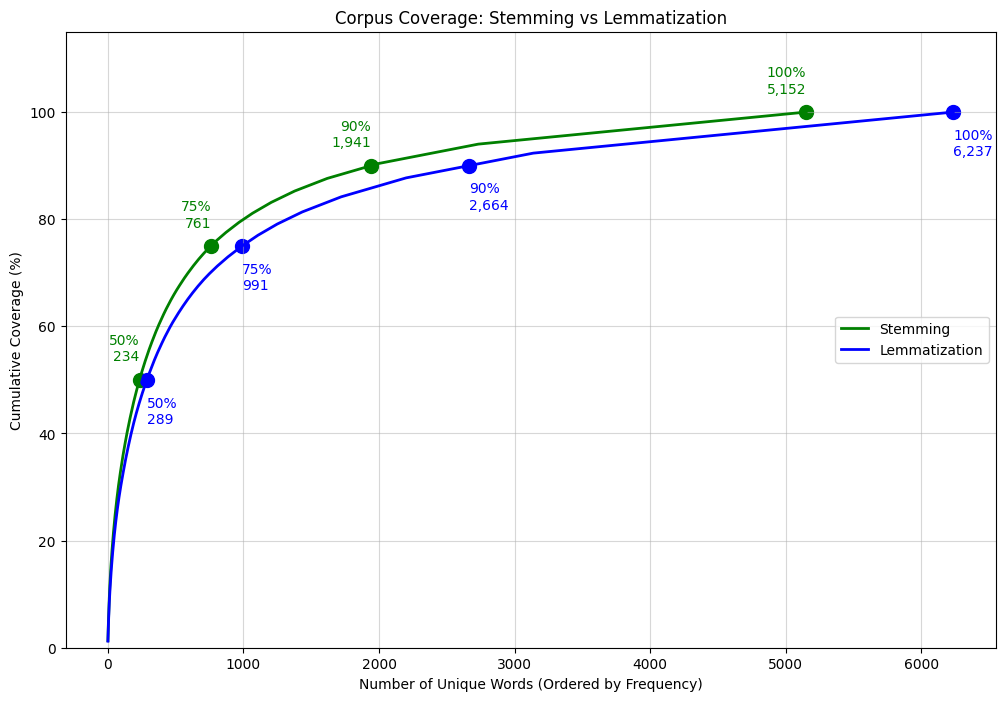

In [ ]:
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt_tab')   # for tokenization
nltk.download('wordnet')     # for lemmatization
nltk.download('stopwords')   # for stopwords
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter

def preprocess_text(text, use_lemmatization=True):
    """
    Preprocesses text by:
      1. Removing HTML tags <br />
      2. Converting to lowercases
      3. Removing punctuation and numbers
      4. Tokenizing into words
      5. Lemmatizing or stemming words
    Args:
        text: the given text to be preprocessed
        use_lemmatization: apply lemmatization if True, stemming otherwise
    Returns:
        tokens: list of preprocessed words
    """
    # Clean text
    text = re.sub(r'<br\s*/?>', ' ', text)  # replace <br>, <br/>, <br /> with space
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^A-Za-z\s]', '', text) # remove punctuation and numbers

    # Tokenize into word-tokens
    tokens = word_tokenize(text) # tokenize (using NLTK's Punkt tokenizer)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming/lemmatization
    ps = PorterStemmer()
    wn = WordNetLemmatizer()
    if use_lemmatization:
        tokens = [wn.lemmatize(word) for word in tokens]
    else:
        tokens = [ps.stem(word) for word in tokens]

    return tokens

# Dictionary to store data and training/testing sets
# Usage: dataframes[norm][item]
#      - norm: 'stem', 'lemma'
#      - item: 'df', 'X_train', 'X_test', 'y_train', 'y_test'
dataframes = {}
norm_types = ['stem', 'lemma']
for norm in norm_types:
    dataframes[norm] = {}

# Plot cumulative coverage %: Stem vs. Lemma
plt.figure(figsize=(12, 8))

for norm in dataframes.keys():
    print(f"\nPreprocessing data ({norm})... ", end='')
    start_time = time.time()

    if norm == 'stem':
        df['Tokens'] = df['Text'].apply(lambda x: preprocess_text(x, False))
        norm_name = 'Stemming'; curve_color = 'green'
        dot_ha = 'right'; dot_va = 'bottom'; yoff = 3
    else: # lemma by default
        df['Tokens'] = df['Text'].apply(lambda x: preprocess_text(x, True))
        norm_name = 'Lemmatization'; curve_color = 'blue'
        dot_ha = 'left'; dot_va = 'top'; yoff = -3

    df['Processed_text'] = df['Tokens'].apply(lambda x: ' '.join(x))
    dataframes[norm]['df'] = df

    all_tokens = [token for sublist in df['Tokens'] for token in sublist]
    all_tokens_size = len(all_tokens)
    vocab = set(all_tokens)
    vocab_size = len(vocab)
    token_freq = Counter(all_tokens)

    print(f"done in {(time.time() - start_time):.2f} seconds.")
    print(f"  - Total token number: {all_tokens_size:,}")
    print(f"  - 10 most common tokens: \n    {token_freq.most_common(10)}")
    print(f"  - Vocabulary size: {vocab_size:,}")
    print(f"  - 10 (arbitrary) tokens in vocabulary: \n    {list(vocab)[:10]}")
    print(f"  - Lexical diversity = {(vocab_size/all_tokens_size):.2f}")
    print(f"  - First 5 rows after preprocessing:")
    print(df[['Score', 'Processed_text', 'Sentiment']].head(5))

    # Compute and plot cumulative coverage
    sorted_freq = [freq for token, freq in token_freq.most_common()]
    cumulative_count = 0
    coverage = []
    check_points = {}
    target_percentages = [50, 75, 90, 100]
    for target in target_percentages:
        check_points[target] = None

    for i, freq in enumerate(sorted_freq):
        cumulative_count += freq
        cover_percent = (cumulative_count / all_tokens_size) * 100
        coverage.append(cover_percent)
        for target in target_percentages:
            if check_points[target] is None and cover_percent >= target:
                check_points[target] = i + 1

    plt.plot(range(vocab_size), coverage, label=norm_name,
             color=curve_color, linewidth=2)
    for y, x in check_points.items():
        plt.scatter(x, y, color=curve_color, marker='o', s=100)
        plt.text(x, y+yoff, f"{y}%\n{x:,}", ha=dot_ha, va=dot_va, color=curve_color)

plt.xlabel('Number of Unique Words (Ordered by Frequency)')
plt.ylabel('Cumulative Coverage (%)')
plt.title('Corpus Coverage: Stemming vs Lemmatization')
plt.ylim(0, 115)
plt.grid(True, alpha=0.5)
plt.legend(loc='center right')
plt.show()

## **3. Data Splitting for Training/Testing Sets**

In [ ]:
from sklearn.model_selection import train_test_split

for norm in dataframes.keys():
    print(f"\nSplitting data ({norm}) into training and testing sets... ", end='')
    start_time = time.time()

    # Split data into train and test sets
    df = dataframes[norm]['df']
    X_train, X_test, y_train, y_test = train_test_split(
        df['Processed_text'], df['Sentiment'], test_size=0.2, random_state=42)

    dataframes[norm]['X_train'] = X_train
    dataframes[norm]['X_test'] = X_test
    dataframes[norm]['y_train'] = y_train
    dataframes[norm]['y_test'] = y_test

    print(f"done in {(time.time() - start_time):.2f} seconds.")
    print(f"  - Total reviews number: {len(df['Sentiment']):,}")
    print(f"  - Training set size: {len(X_train):,}")
    print(f"  - Testing set size: {len(X_test):,}")


Splitting data (stem) into training and testing sets... done in 0.00 seconds.
  - Total reviews number: 1,000
  - Training set size: 800
  - Testing set size: 200

Splitting data (lemma) into training and testing sets... done in 0.00 seconds.
  - Total reviews number: 1,000
  - Training set size: 800
  - Testing set size: 200


## **4. Feature Representation**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
feature_types = ['TF', 'TFIDF']

def vectorize_text(tokens, vec_type='TFIDF', max_features=5000):
    """
    Converts a list of tokens into numerical feature vectors using TF or TF-IDF.
    Args:
        tokens: a list of preprocessed text tokens
        vec_type: 'TF' for CountVectorizer or 'TFIDF' for TfidfVectorizer
        max_features: current vocab size ~57,000, limit feature vector size
    Returns:
        X: matrix of features
        vectorizer: the fitted vectorizer object
    """
    start_time = time.time()

    if vec_type == 'TF':
        vectorizer = CountVectorizer(max_features=max_features)
    else: # otherwise, 'TFIDF' by default
        vectorizer = TfidfVectorizer(max_features=max_features)

    X = vectorizer.fit_transform(tokens)

    return X, vectorizer

## **5. Create and Train Classification Models: NB, LR, MLP**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

model_names = ['Naive Bayes', 'Logistic Regression', 'MLP']
model_types = ['NB', 'LR', 'MLP']

def create_train_eval_model(X_train, X_test, y_train, y_test, norm):
    """
    Creates, trains, and evaluates the classifier models.
    For the model's performance,
                             Predicted
           |          | Negative | Positive |
    Actual | Negative |    TN    |    FP    |
           | Positive |    FN    |    TP    |

    - Accuracy  = (TP+TN) / (TP+TN+FP+FN) : overall correctness
    - Precision = TP / (TP+FP)            : actual P of all P predictions
    - Recall    = TP / (TP+FN)            : correctly identified of all actual P
    - F1        = 2*Prec*Rec / (Prec+Rec) : harmonic mean of precision and recall

    Args:
        X_train: training feature matrix
        X_test: testing feature matrix
        y_train: training labels
        y_test: testing (true) labels
        norm: 'stem' for stemming, 'lemma' for lemmatization
    Returns:
        metrics: dictionary of model evaluation metrics
    """

    metrics = {}
    models = {
        'NB': { # Naive Bayes
            'TF': MultinomialNB(),
            'TFIDF': MultinomialNB()
        },
        'LR': { # Logistic Regression
            'TF': LogisticRegression(max_iter=500),
            'TFIDF': LogisticRegression(max_iter=500)
        },
        'MLP': { # Multilayer Perceptron, single hidden layer of 100 neurons
            'TF': MLPClassifier(solver='adam',
                hidden_layer_sizes=(100,), max_iter=200,
                early_stopping=True, n_iter_no_change=10),
            'TFIDF': MLPClassifier(solver='adam',
                hidden_layer_sizes=(100,), max_iter=200,
                early_stopping=True, n_iter_no_change=10)
        }
    }

    print(f"\nTraining and evaluating models ({norm}):")
    for model_type in model_types:
        metrics[model_type] = {}

        for feature in feature_types:
            print(f"  - Training {model_type} model with {feature}... ", end='')
            start_time = time.time()

            # Vectorize text
            X_train_featured, vectorizer = vectorize_text(X_train, feature)
            X_test_featured = vectorizer.transform(X_test)

            # Train the model
            model = models[model_type][feature]
            model.fit(X_train_featured, y_train)

            # Get predictions and probabilities
            y_pred = model.predict(X_test_featured)
            y_proba = model.predict_proba(X_test_featured)[:, 1] # prob of pos

            # Evaluate model's performance
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            cm = confusion_matrix(y_test, y_pred)
            fpr, tpr, _ = roc_curve(y_test, y_proba) # threshold not used
            roc_auc = auc(fpr, tpr)

            metrics[model_type][feature] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'cm': cm,
                'fpr': fpr,
                'tpr': tpr,
                'auc': roc_auc,
                'model': model,
                'vectorizer': vectorizer,
                'training_time': time.time() - start_time
            }

            print(f"done in {(time.time() - start_time):.2f} seconds, "
                  f"accuracy: {accuracy:.4f}")

    return metrics

# Dictionary to store data and training/testing sets
# Usage: results[norm][model][feature][item]
#      - norm: 'stem', 'lemma'
#      - model: 'NB', 'LR', 'MLP'
#      - feature: 'TF', 'TFIDF'
#      - item: 'accuracy', 'precision', 'recall', 'f1', 'cm',
#              'fpr', 'tpr', 'auc', 'model', 'vectorizer', 'training_time'
results = {}

for norm in norm_types:
    results[norm] = create_train_eval_model(
        dataframes[norm]['X_train'],
        dataframes[norm]['X_test'],
        dataframes[norm]['y_train'],
        dataframes[norm]['y_test'], norm)


Training and evaluating models (stem):
  - Training NB model with TF... done in 0.10 seconds, accuracy: 0.8250
  - Training NB model with TFIDF... done in 0.07 seconds, accuracy: 0.8150
  - Training LR model with TF... done in 0.09 seconds, accuracy: 0.7850
  - Training LR model with TFIDF... done in 0.12 seconds, accuracy: 0.8450
  - Training MLP model with TF... done in 2.52 seconds, accuracy: 0.8200
  - Training MLP model with TFIDF... done in 2.88 seconds, accuracy: 0.8150

Training and evaluating models (lemma):
  - Training NB model with TF... done in 0.09 seconds, accuracy: 0.8250
  - Training NB model with TFIDF... done in 0.06 seconds, accuracy: 0.8150
  - Training LR model with TF... done in 0.10 seconds, accuracy: 0.7850
  - Training LR model with TFIDF... done in 0.11 seconds, accuracy: 0.8450
  - Training MLP model with TF... done in 1.09 seconds, accuracy: 0.8000
  - Training MLP model with TFIDF... done in 1.59 seconds, accuracy: 0.8050


## **6. Visualize Model Performance Metrics**


Generating plot for model performance comparison (Stemming vs Lemmatization)... done in 1.05 seconds.


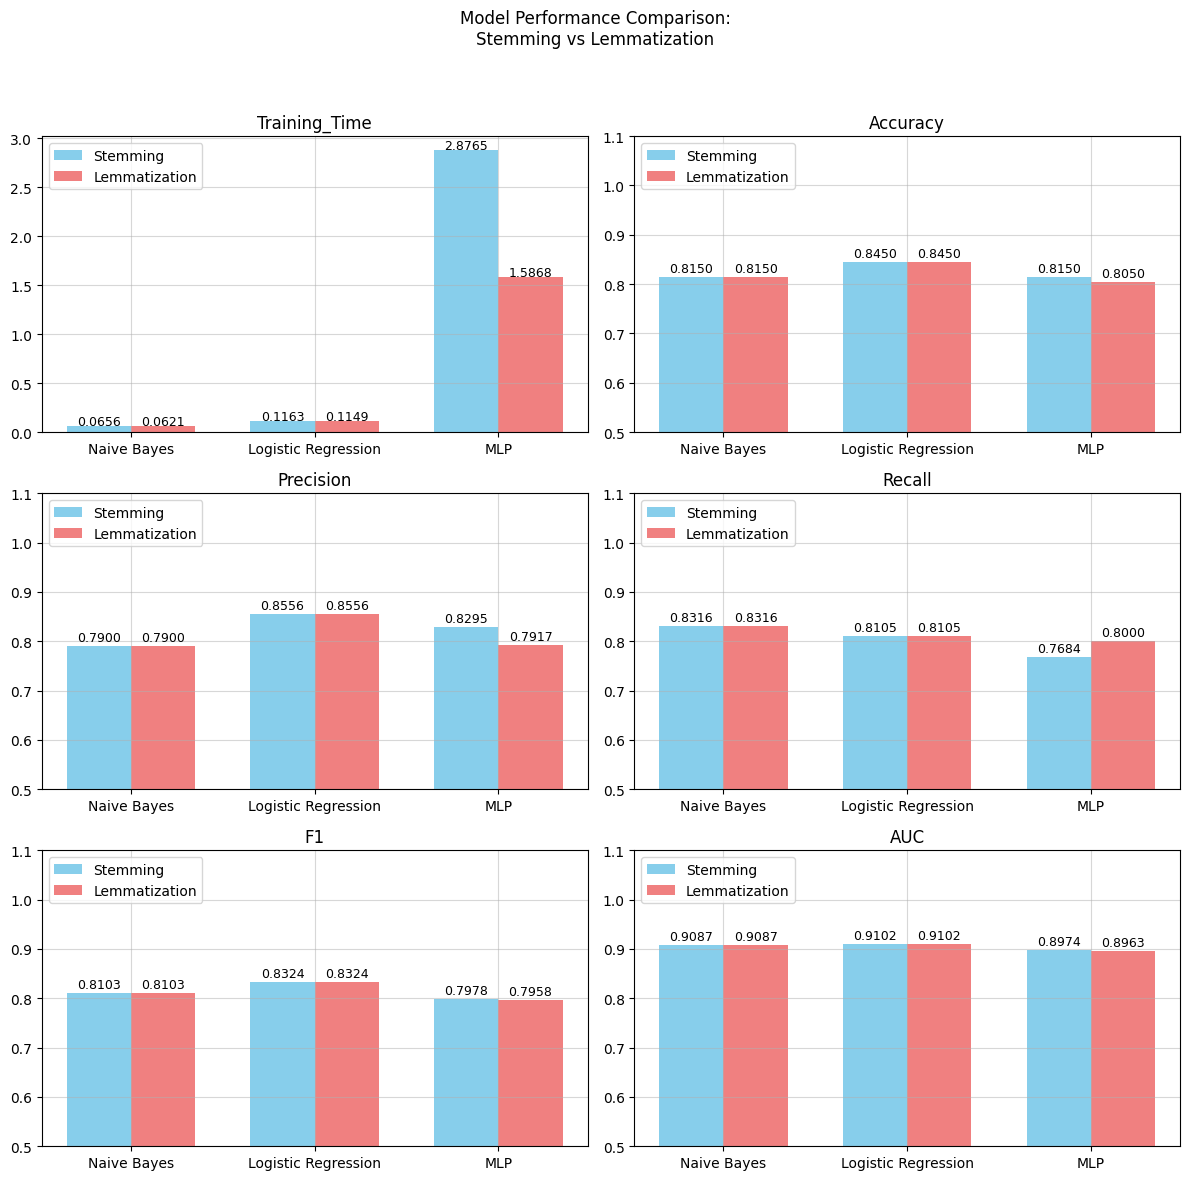

In [ ]:
import numpy as np

def plot_subplot_barchart(subchart, item, for_feature=True):
    """
    Helper function to plot each comparison subplot (bar-chart).
    Args:
        subchart: the subplot object
        item: comparison target, e.g. 'Accuracy', 'Precision'
        for_feature: True for comparing TF vs TFIDF, False for stem vs lemma
    """
    x = np.arange(len(model_names))
    width = 0.35
    if for_feature:
        val1 = [results['lemma'][model]['TF'][item.lower()] for model in model_types]
        val2 = [results['lemma'][model]['TFIDF'][item.lower()] for model in model_types]
        label1 = 'TF'; label2 = 'TF-IDF'
    else: # for norm
        val1 = [results['stem'][model]['TFIDF'][item.lower()] for model in model_types]
        val2 = [results['lemma'][model]['TFIDF'][item.lower()] for model in model_types]
        label1 = 'Stemming'; label2 = 'Lemmatization'

    subchart.set_title(f"{item}")
    subchart.set_xticks(x)
    subchart.set_xticklabels(model_names)
    subchart.bar(x - width/2, val1, width, label=label1, color='skyblue')
    subchart.bar(x + width/2, val2, width, label=label2, color='lightcoral')
    subchart.legend(loc='upper left')
    subchart.grid(True, alpha=0.5)
    if item != 'Training_Time': subchart.set_ylim(0.5, 1.1)

    for i, v in enumerate(val1):
        subchart.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)
    for i, v in enumerate(val2):
        subchart.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center', fontsize=9)

def plot_comparison_by_feature(for_feature=True):
    """
    Create 3x2 subplot for model performance comparison.
    Args:
        for_feature: True for comparing TF vs TFIDF, False for stem vs lemma
    """
    if for_feature:
        subject = 'TF vs TF-IDF'
    else:
        subject = 'Stemming vs Lemmatization'

    print(f"Generating plot for model performance comparison ({subject})... ", end='')
    start_time = time.time()

    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    fig.suptitle(f"Model Performance Comparison:\n{subject}")

    # Plot comparison charts
    plot_subplot_barchart(axes[0, 0], 'Training_Time', for_feature)
    plot_subplot_barchart(axes[0, 1], 'Accuracy', for_feature)
    plot_subplot_barchart(axes[1, 0], 'Precision', for_feature)
    plot_subplot_barchart(axes[1, 1], 'Recall', for_feature)
    plot_subplot_barchart(axes[2, 0], 'F1', for_feature)
    plot_subplot_barchart(axes[2, 1], 'AUC', for_feature)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    print(f"done in {(time.time() - start_time):.2f} seconds.")
    plt.show()

def plot_ROC():
    """
    Plot ROC curves for each model and feature. (Lemma normalization)
    """
    print("Generating plot for ROC comparison... ", end='')
    start_time = time.time()

    plt.figure(figsize=(12, 8))

    for model in model_types:
        for feature in feature_types:
            plt.plot(
                results['lemma'][model][feature]['fpr'],
                results['lemma'][model][feature]['tpr'],
                label=(f"{model} ({feature}) - "
                       f"AUC: {results['lemma'][model][feature]['auc']:.4f}"),
                linestyle='-', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3,
             label='Random Classifier - AUC: 0.5') # reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Comparison')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.5)

    print(f"done in {(time.time() - start_time):.2f} seconds.")
    plt.show()

print()
plot_comparison_by_feature(False) # comparison: Stemming vs Lemmatization

Generating plot for model performance comparison (TF vs TF-IDF)... done in 0.45 seconds.


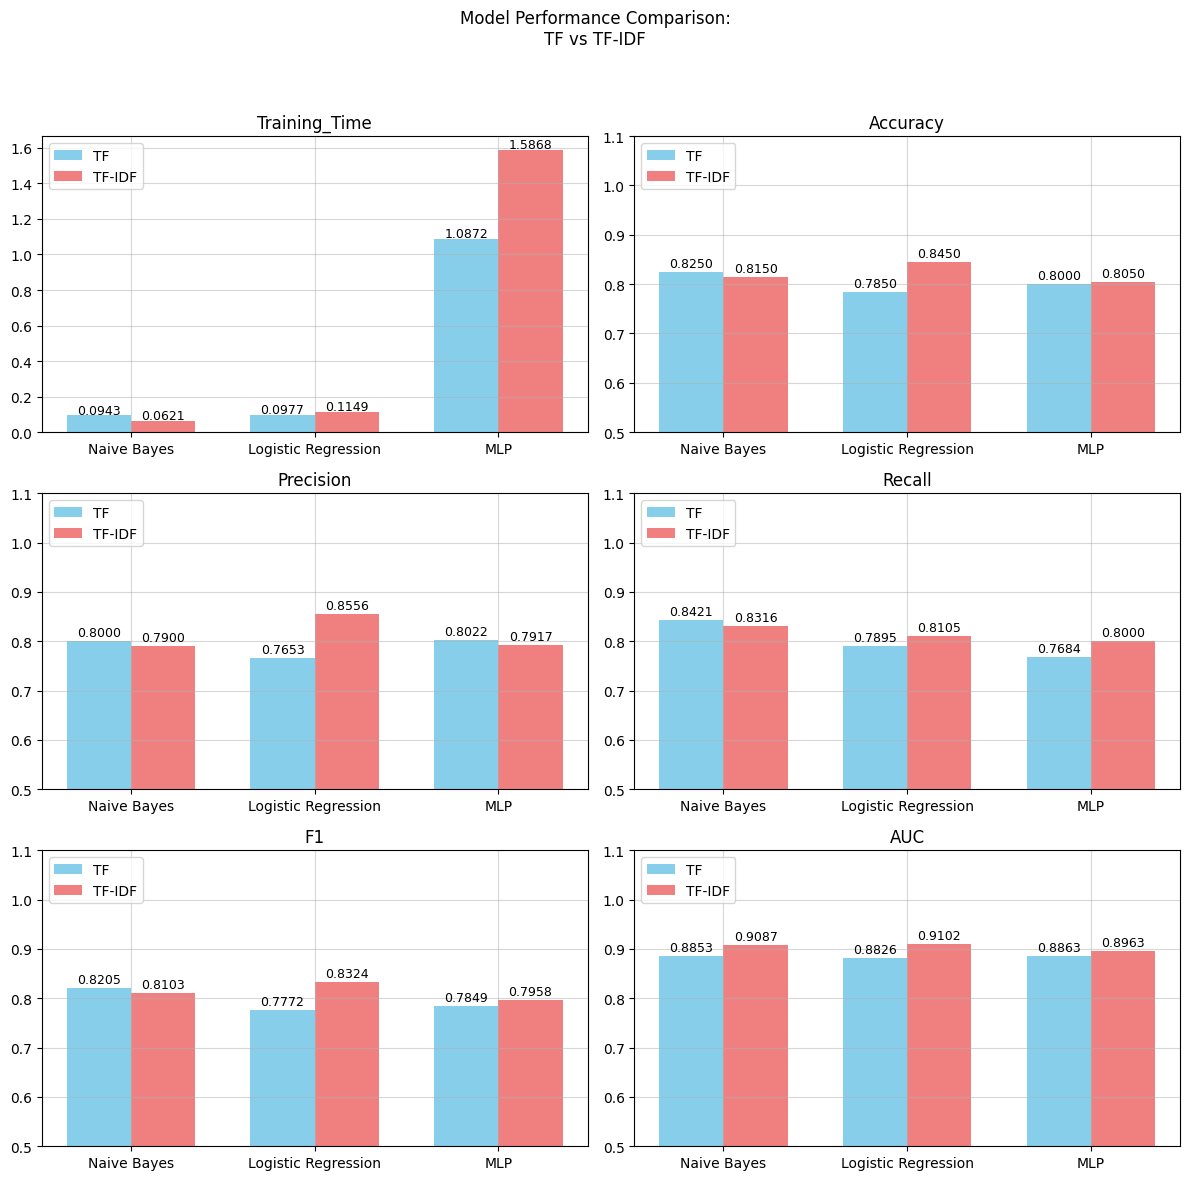

In [ ]:
plot_comparison_by_feature(True)  # comparison: TF vs TF-IDF

Generating plot for ROC comparison... done in 0.02 seconds.


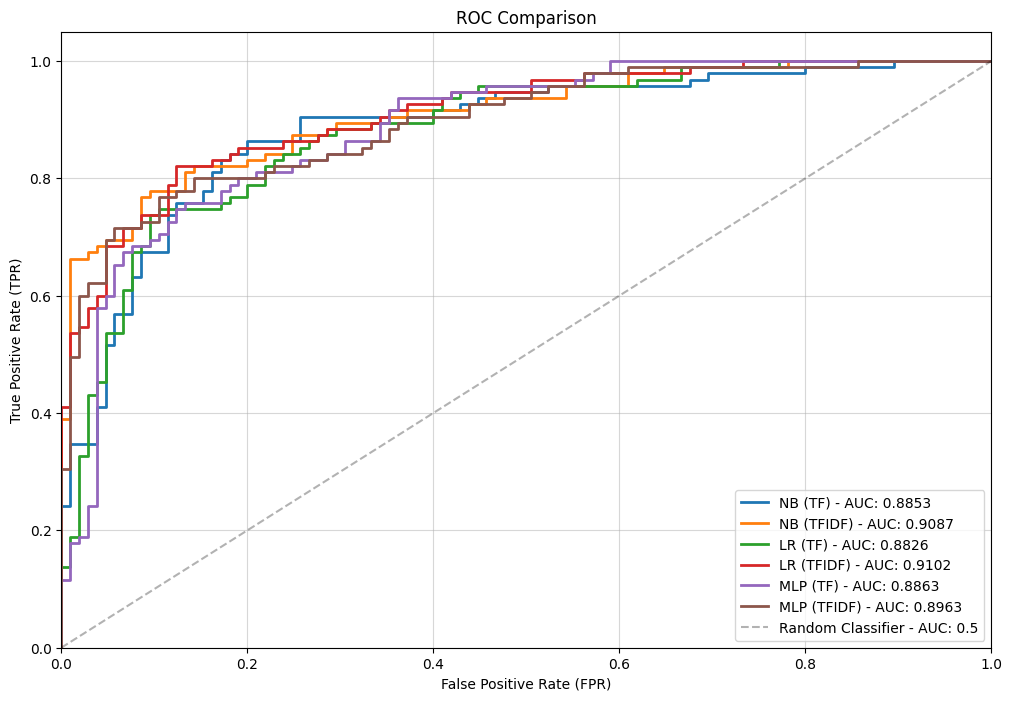

In [ ]:
plot_ROC()                        # ROC curves for each model, feature

## **7. Clustering Analysis**


Evaluation with confusion matrices and t-SNE:
  - Applying K-Means clustering (unsupervised, whole sampled set)...
  - Generating for NB (supervised, test set)...
  - Generating for LR (supervised, test set)...
  - Generating for MLP (supervised, test set)...
  - Plotting confusion matrices... 


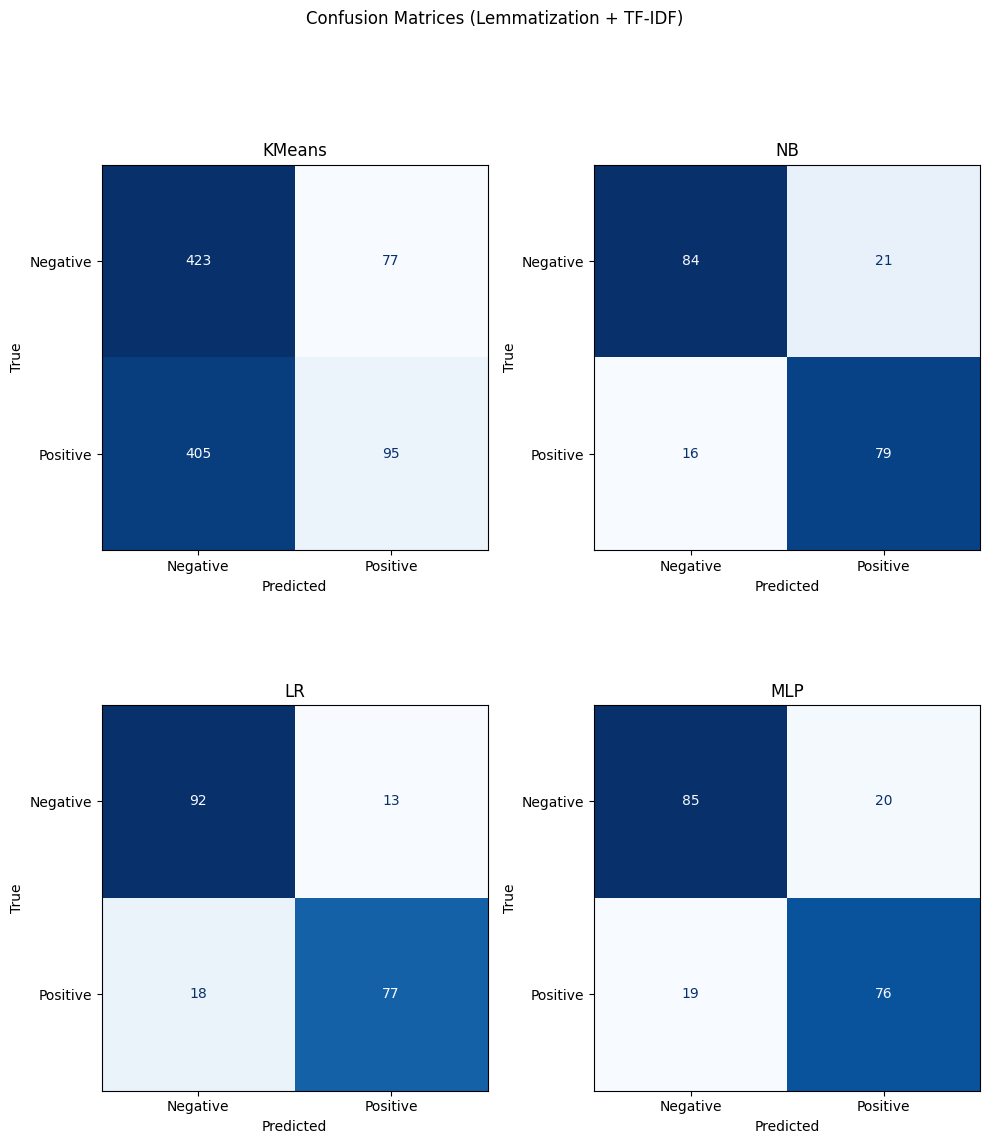

  - Plotting t-SNE visualization... 


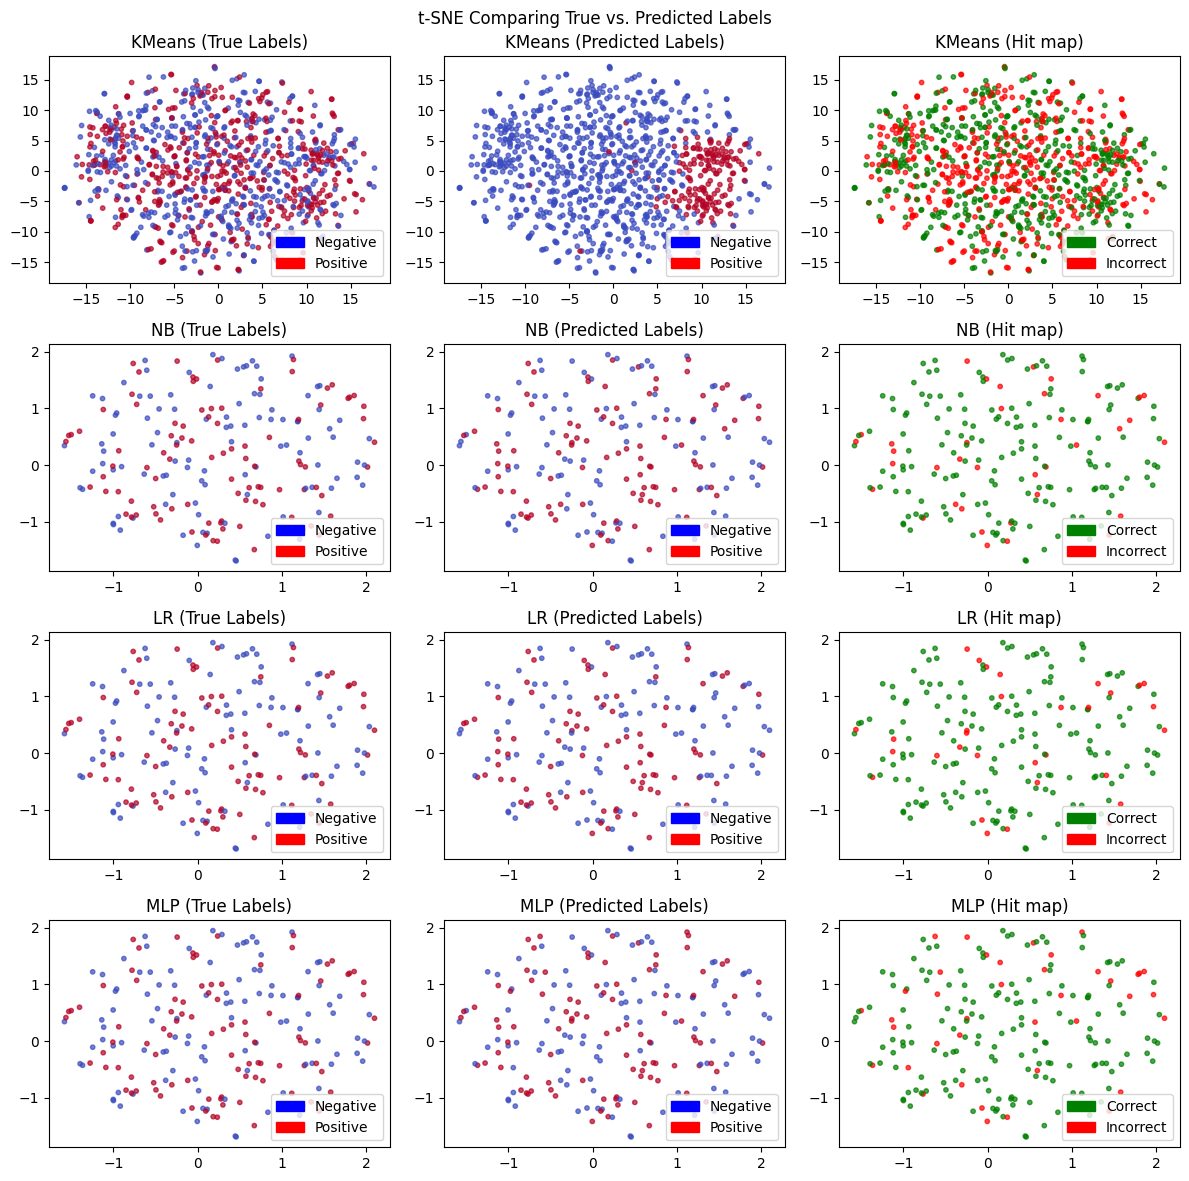

done.


In [ ]:
import matplotlib.patches as mpatches
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_and_tsne():
    """
    1. Perform K-Means clustering (unsupervised, whole sampled set), and
       classification with NB, LR, MLP (supervised, test set)
    2. Re-map the predicted labels to news categories based on optimal matching
    3. Plots the confusion matrices and t-SNE (K-Means, NB, LR, MLP)
    """
    print("\nEvaluation with confusion matrices and t-SNE:")

    model_names = ['KMeans', 'NB', 'LR', 'MLP']
    target_names = ['Negative', 'Positive']
    cm_list = []
    X_tsne_list = []
    y_predict_list = []
    y_true_list = []

    # 1: KMeans (unsupervised, whole sampled set)
    print(f"  - Applying K-Means clustering (unsupervised, whole sampled set)...")

    X_featured, vectorizer = vectorize_text(
        dataframes['lemma']['df']['Processed_text'], 'TFIDF')
    true_labels = dataframes['lemma']['df']['Sentiment']

    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    y_kmeans = kmeans.fit_predict(X_featured)

    # Hungarian matching to align cluster labels with sentiment labels
    # - K-Means assigns arbitrary cluster labels (0/1) that may not match
    #   the sentiment labels (0=negative, 1=positive)
    # - Find optimal mapping by:
    #   1. Compute confusion matrix between true labels and cluster assignments
    #   2. Find the mapping that maximizes the diagonal sum (correct assignments)
    #   3. Use linear_sum_assignment to find min cost (-cm_kmeans)
    cm_kmeans = confusion_matrix(true_labels, y_kmeans)
    _, col_ind = linear_sum_assignment(-cm_kmeans) # row_ind not used
    y_kmeans_aligned = np.array([col_ind[label] for label in y_kmeans])

    cm_list.append(confusion_matrix(true_labels, y_kmeans_aligned))
    X_tsne_list.append(TSNE(
            n_components=2,   # dimension of the embedded space
            random_state=42,  # random number generation
            perplexity=100,   # related to the number of nearest neighbors
            max_iter=500      # maximum num of iterations for the optimization
        ).fit_transform(X_featured.toarray()))
    y_predict_list.append(y_kmeans_aligned)
    y_true_list.append(true_labels)

    # 2–4: NB, LR, MLP (supervised, test set)
    for model_name in ['NB', 'LR', 'MLP']:
        print(f"  - Generating for {model_name} (supervised, test set)...")

        model = results['lemma'][model_name]['TFIDF']['model']
        vectorizer = results['lemma'][model_name]['TFIDF']['vectorizer']
        X_test = vectorizer.transform(dataframes['lemma']['X_test'])
        y_test = dataframes['lemma']['y_test']
        y_pred = model.predict(X_test)
        cm_list.append(confusion_matrix(y_test, y_pred))
        X_tsne_list.append(TSNE(
            n_components=2,   # dimension of the embedded space
            random_state=42,  # random number generation
            perplexity=100,   # related to the number of nearest neighbors
            max_iter=500      # maximum num of iterations for the optimization
        ).fit_transform(X_test.toarray()))
        y_predict_list.append(y_pred)
        y_true_list.append(y_test)

    # Plot confusion matrices
    print(f"  - Plotting confusion matrices... ")

    fig1, axes1 = plt.subplots(2, 2, figsize=(10, 12))
    fig1.suptitle("Confusion Matrices (Lemmatization + TF-IDF)")

    for i, cm in enumerate(cm_list):
        ax = axes1[i // 2, i % 2]
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title(f'{model_names[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


    # Plot t-SNE visualizations for comparing true vs predicted labels
    print(f"  - Plotting t-SNE visualization... ")

    fig3, axes3 = plt.subplots(4, 3, figsize=(12, 12))
    fig3.suptitle(f"t-SNE Comparing True vs. Predicted Labels")

    for row, model_name in enumerate(model_names):
        X = X_tsne_list[row]
        y_true = y_true_list[row]
        y_pred = y_predict_list[row]
        y_hits = (y_true == y_pred)
        hit_colors = ['green' if hit else 'red' for hit in y_hits]

        # LEFT: t-SNE colored by true labels
        ax = axes3[row, 0]
        ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap='coolwarm', s=10, alpha=0.7)
        ax.set_title(f'{model_name} (True Labels)')
        legend_labels = [mpatches.Patch(color='blue', label='Negative'),
                         mpatches.Patch(color='red', label='Positive')]
        ax.legend(handles=legend_labels, loc='lower right')

        # MIDDLE: t-SNE colored by predicted labels
        ax = axes3[row, 1]
        ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm', s=10, alpha=0.7)
        ax.set_title(f'{model_name} (Predicted Labels)')
        ax.legend(handles=legend_labels, loc='lower right')

        # RIGHT: t-SNE colored by TRUE labels
        ax = axes3[row, 2]
        ax.scatter(X[:, 0], X[:, 1], c=hit_colors, s=10, alpha=0.7)
        ax.set_title(f'{model_name} (Hit map)')
        legend_hits = [mpatches.Patch(color='green', label='Correct'),
                   mpatches.Patch(color='red', label='Incorrect')]
        ax.legend(handles=legend_hits, loc='lower right')

    plt.tight_layout()
    plt.show()

    print("done.")

plot_confusion_and_tsne()